# 3: PREDICTIVE MODEL

Fit a model using the features derived on STEP 2, with the composite score as a target. The model then predicts ”hit movie” score.

LightGBM was preferred over other models because it's faster and uses less memory, especially on large datasets. This proves to be advantageous, especially on STEP 4 (finding model maxima) which attempts to find the maxima of the fitted model. It also handles large numbers of features well without the need for extensive preprocessing.

Optuna was used to find the optimal hyperparameters.



## IMPORT PACKAGES

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 500)

In [2]:
# Load data
train = pd.read_csv('processed_data/train.csv', index_col=0).dropna()
val = pd.read_csv('processed_data/val.csv', index_col=0).dropna()
test = pd.read_csv('processed_data/test.csv', index_col=0).dropna()

print(train.shape)
print(val.shape)
print(test.shape)

(163836, 32)
(54602, 32)
(54569, 32)


In [3]:
# Separate features and target
X_train = train.drop(columns=['averageRating','primaryTitle','composite_score', 'startYear',
                              'gross_income_log','numVotes_log'], axis=1)
y_train = train['composite_score']

# Separate features and target
X_val = val.drop(columns=['averageRating','primaryTitle','composite_score', 'startYear',
                              'gross_income_log','numVotes_log'], axis=1)
y_val = val['composite_score']

# Separate features and target
X_test = test.drop(columns=['averageRating','primaryTitle','composite_score', 'startYear',
                              'gross_income_log','numVotes_log'], axis=1)
y_test = test['composite_score']

In [4]:
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

## HYPERPARAMETER TUNING
The function `find_best_model` employs hyperparameter tuning with the Optuna framework to optimize a LightGBM regression model. It defines a set of parameters, performs 5-fold cross-validation to evaluate the model's performance based on mean squared error (MSE), and uses 100 trials to find the best settings. The function ultimately returns the optimal parameters and the lowest MSE achieved.

In [6]:
def find_best_model(X, y):
    
    def objective(trial):

        params = {
            'objective': 'regression',
            'metric': 'mse',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 100.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 100.0, log=True),
        }

        # Perform k-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        mse_scores = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            dtrain = lgb.Dataset(X_train, label=y_train)
            dval = lgb.Dataset(X_val, label=y_val)

            model = lgb.train(params, dtrain, valid_sets=[dval])
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

        return np.mean(mse_scores)
    
    study=optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    
    return study.best_params, study.best_value

## MODELING

In [7]:
best_params, best_value = find_best_model(X=X_trainval, y=y_trainval)
print("Best params: ", best_params)
print()
print("Best value: ", best_value)

[I 2024-05-11 16:25:12,219] A new study created in memory with name: no-name-65b05727-29ff-4b31-809d-cf5364a5f396
[I 2024-05-11 16:25:32,145] Trial 0 finished with value: 0.010899320234301473 and parameters: {'num_leaves': 241, 'learning_rate': 0.0018578810155254577, 'feature_fraction': 0.15587619676770478, 'bagging_fraction': 0.5770900613005214, 'bagging_freq': 1, 'min_child_samples': 67, 'reg_alpha': 4.4045010655249545e-06, 'reg_lambda': 9.579366707173066e-06}. Best is trial 0 with value: 0.010899320234301473.
[I 2024-05-11 16:25:34,961] Trial 1 finished with value: 0.010877020486333737 and parameters: {'num_leaves': 2, 'learning_rate': 0.0033361902363624038, 'feature_fraction': 0.45124416710035786, 'bagging_fraction': 0.9443741813130887, 'bagging_freq': 6, 'min_child_samples': 52, 'reg_alpha': 3.0813100158001106e-05, 'reg_lambda': 9.217323425352218e-08}. Best is trial 1 with value: 0.010877020486333737.
[I 2024-05-11 16:25:41,024] Trial 2 finished with value: 0.003524506256197059 an

[I 2024-05-11 16:30:05,722] Trial 21 finished with value: 0.002333142849873786 and parameters: {'num_leaves': 37, 'learning_rate': 0.2925133657999984, 'feature_fraction': 0.7694023914677746, 'bagging_fraction': 0.9980608129542093, 'bagging_freq': 7, 'min_child_samples': 26, 'reg_alpha': 2.222248749535064, 'reg_lambda': 1.1471715951845247}. Best is trial 5 with value: 0.002297777163765496.
[I 2024-05-11 16:30:14,243] Trial 22 finished with value: 0.0023557349267728503 and parameters: {'num_leaves': 39, 'learning_rate': 0.33012777906440643, 'feature_fraction': 0.783819976502832, 'bagging_fraction': 0.9972800843045432, 'bagging_freq': 8, 'min_child_samples': 12, 'reg_alpha': 3.963795679339416, 'reg_lambda': 1.6099188678815877}. Best is trial 5 with value: 0.002297777163765496.
[I 2024-05-11 16:30:23,344] Trial 23 finished with value: 0.002320199567193616 and parameters: {'num_leaves': 47, 'learning_rate': 0.19658975256596603, 'feature_fraction': 0.8910132959799053, 'bagging_fraction': 0.8

[I 2024-05-11 16:33:27,077] Trial 42 finished with value: 0.0024176801942279607 and parameters: {'num_leaves': 73, 'learning_rate': 0.19276618606468693, 'feature_fraction': 0.5439638680805714, 'bagging_fraction': 0.9593297074813635, 'bagging_freq': 6, 'min_child_samples': 9, 'reg_alpha': 8.56264936163421, 'reg_lambda': 19.572622734517886}. Best is trial 5 with value: 0.002297777163765496.
[I 2024-05-11 16:33:35,529] Trial 43 finished with value: 0.0024082729554974034 and parameters: {'num_leaves': 33, 'learning_rate': 0.10525899101005651, 'feature_fraction': 0.6147912296357481, 'bagging_fraction': 0.9028988769687314, 'bagging_freq': 8, 'min_child_samples': 18, 'reg_alpha': 0.2619451911934987, 'reg_lambda': 0.052474083773798495}. Best is trial 5 with value: 0.002297777163765496.
[I 2024-05-11 16:33:42,709] Trial 44 finished with value: 0.0026326185932309455 and parameters: {'num_leaves': 92, 'learning_rate': 0.6260912039995876, 'feature_fraction': 0.3888315910684097, 'bagging_fraction':

[I 2024-05-11 16:38:16,840] Trial 63 finished with value: 0.00227537484754398 and parameters: {'num_leaves': 128, 'learning_rate': 0.11856763604143607, 'feature_fraction': 0.7447466305355948, 'bagging_fraction': 0.6916785707433002, 'bagging_freq': 1, 'min_child_samples': 71, 'reg_alpha': 0.04529902079781925, 'reg_lambda': 7.14181503528611e-06}. Best is trial 63 with value: 0.00227537484754398.
[I 2024-05-11 16:38:29,643] Trial 64 finished with value: 0.0022744941650222742 and parameters: {'num_leaves': 126, 'learning_rate': 0.11597343052506957, 'feature_fraction': 0.7464623200826087, 'bagging_fraction': 0.7029771113043287, 'bagging_freq': 1, 'min_child_samples': 70, 'reg_alpha': 0.033526652086277864, 'reg_lambda': 5.236826231157545e-06}. Best is trial 64 with value: 0.0022744941650222742.
[I 2024-05-11 16:38:44,411] Trial 65 finished with value: 0.002273158429459092 and parameters: {'num_leaves': 150, 'learning_rate': 0.10049545315003759, 'feature_fraction': 0.7329329278506966, 'baggin

[I 2024-05-11 16:44:20,706] Trial 84 finished with value: 0.0022942363363289728 and parameters: {'num_leaves': 125, 'learning_rate': 0.08456045228748368, 'feature_fraction': 0.716658399430735, 'bagging_fraction': 0.5781114202602174, 'bagging_freq': 2, 'min_child_samples': 73, 'reg_alpha': 0.0651253884695626, 'reg_lambda': 1.2282673213427044e-08}. Best is trial 65 with value: 0.002273158429459092.
[I 2024-05-11 16:44:34,538] Trial 85 finished with value: 0.002277770630872508 and parameters: {'num_leaves': 136, 'learning_rate': 0.12291318614912379, 'feature_fraction': 0.642093440512666, 'bagging_fraction': 0.6995118620725843, 'bagging_freq': 1, 'min_child_samples': 78, 'reg_alpha': 0.2593523852678436, 'reg_lambda': 3.1856409122049986e-07}. Best is trial 65 with value: 0.002273158429459092.
[I 2024-05-11 16:44:48,946] Trial 86 finished with value: 0.0023191204705550264 and parameters: {'num_leaves': 134, 'learning_rate': 0.25374154944409305, 'feature_fraction': 0.6376736928861957, 'baggin

Best params:  {'num_leaves': 255, 'learning_rate': 0.07363657088697936, 'feature_fraction': 0.7843836944815351, 'bagging_fraction': 0.8173223545509594, 'bagging_freq': 1, 'min_child_samples': 67, 'reg_alpha': 0.13374605101635914, 'reg_lambda': 3.5207667328307918e-06}

Best value:  0.0022478606739318625


## RETRAIN ON BEST PARAMETERS

In [ ]:
# Create LightGBM datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_val, label=y_val)

best_params['objective'] = 'regression'
best_params['metric'] = 'mse',
best_params['boosting_type'] = 'gbdt'

best_model = lgb.train(best_params, dtrain, valid_sets=[dvalid])

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Assuming you have X_test and y_test ready

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

Mean Squared Error: 0.0022934925078014895
Root Mean Squared Error: 0.04789042187955217
MAPE: 0.1012676421481616


## PLOTTING FEATURE IMPORTANCES

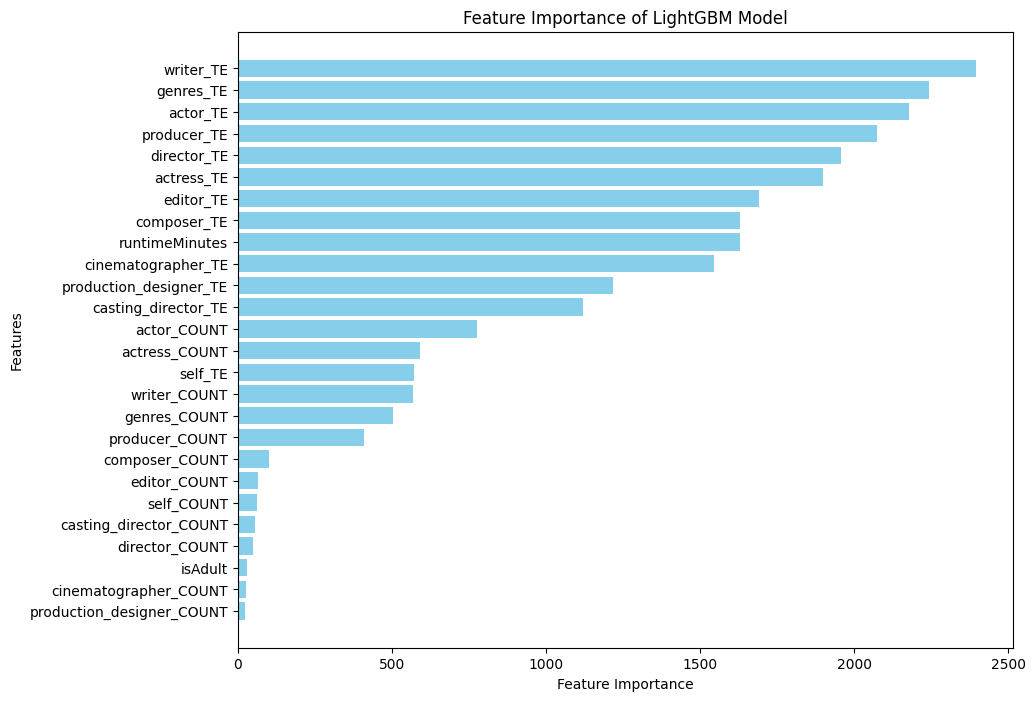

In [6]:
import matplotlib.pyplot as plt
    
features = best_model.feature_name()
importances = best_model.feature_importance()

# Combine into a list of tuples and sort by importance
feature_importance = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

# Unpack the sorted items
sorted_features, sorted_importances = zip(*feature_importance)

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of LightGBM Model')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important feature at the top
plt.show()

## MODELING INSIGHTS

**1. Top Influencers**
* The writer (writer_TE), genres (genres_TE), and actors (actor_TE) are the most significant predictors, indicating that creative talent and content type are crucial determinants of a film’s outcomes.

**2. Important Production Roles**
* Other significant roles include directors, composers, and producers, underscoring that the entire production team's influence is vital.

**3. Feature Types**
* Target-encoded features show higher importance than count-based features, suggesting that the impact of individuals or genres is more critical than their mere presence.

**4. Less Influential Roles**
* Roles like cinematographers and production designers, while important artistically, have less impact on the model's predictions.

## Save model

In [12]:
import pickle
from datetime import datetime

curr_time = datetime.today().strftime('%Y-%m-%d %H-%M-%S')
model_name = best_model.__class__.__name__

MODEL_FILENAME = f'./models/{curr_time}_{model_name}.pkl'

pickle.dump(best_model, open(MODEL_FILENAME, 'wb'))
print(MODEL_FILENAME)

./models/2024-05-11 16-49-39_Booster.pkl
